# Low-Rank Approximation for Movie Recommendations

A common application of low-rank approximation is for recommender systems. 

## Loading the MovieLens Dataset

We first load some common packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[GroupLens](https://grouplens.org/) is a research organization at the University of Minnesota that has done extensive work in recommendation systems among other topics.  They have excellent datasets on movie recommendations as part of their [MovieLens project](https://movielens.org/).  Here the dataset is relatively small, `Movielens 1m` that has 1 million ratings.

To get the data, go to the webpage:

https://grouplens.org/datasets/movielens/latest/

In [2]:
import tqdm
import requests
import os
import zipfile

# Set the files names for movies and ratings files
ml_dir = 'ml-1m'
ratings_fn = os.path.join(ml_dir,'ratings.dat')
movies_fn = os.path.join(ml_dir,'movies.dat')

def download_file(src_url, dst_fn):
    
    if os.path.exists(dst_fn):
        print('File %s already exists' % dst_fn)
        return
    
    print('Downloading %s' % dst_fn)
    
    # Streaming, so we can iterate over the response.
    r = requests.get(src_url, stream=True)

    # Total size in MB.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    wrote = 0 
    with open(dst_fn, 'wb') as f:
        with tqdm.tqdm_notebook(total=total_size//block_size, unit='kB', 
                           unit_scale=True, unit_divisor=1024) as pbar:
            for data in r.iter_content(block_size):
                wrote = wrote + len(data)
                pbar.update(1)
                f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong") 

# Test if all files are downloaded
files_exists = False
if os.path.exists(ml_dir):
    if os.path.exists(ratings_fn) and os.path.exists(movies_fn):
        files_exists = True

if files_exists:
    print('Files %s and %s already downloaded' % (ratings_fn, movies_fn))

else:
    # First download the zip file if needed
    src_url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
    dst_fn = 'ml-1m.zip'
    download_file(src_url, dst_fn)
    
    # Then, unzip the file
    print('Unzipping %s...' % dst_fn)
    zip_ref = zipfile.ZipFile(dst_fn, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Unzip completed')

Files ml-1m/ratings.dat and ml-1m/movies.dat already downloaded


Read the movies files with the `read_csv` command.  Print the first 5 entries of the dataframe.  You will see that the file has a list of movies.  Each movie has a `movieId` and `title`.

In [3]:
# Read the movies 
import os
movies = pd.read_csv(movies_fn, sep='::', engine='python', encoding='latin-1', names=['movieId', 'title', 'genre'])

# Use the movies.head() to display the first 5 entries
movies.head()

,movieId,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Extracted the following columns from the `movies` dataframe:
*  Extracted the `movieId` column, convert to an `np.array` and store in `movie_ids`
*  Extracted the `title` column, convert to a list (using `.tolist()`) and store in `titles`

In [4]:
movie_ids = np.array(movies['movieId'], dtype=int)
titles = movies['title'].tolist()

The following function returns the string of a movie title, given its movie id.

In [5]:
def get_movie_title(movie_id):
    I = np.where(movie_ids == movie_id)[0]
    if len(I) == 0:
        return 'unknown'
    else:
        return titles[I[0]]

Load the `ratings.dat` file into a `pandas` dataframe `ratings`.  Use the `head` method to print the first five rows of the dataframe.  This is a large file, so it may take a minute to read in.

In [6]:
ratings = pd.read_csv(ratings_fn, sep='::', engine='python', encoding='latin-1', names=['userId', 'movieId', 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Extracted three columns from the `ratings` dataframe:

* Set `user` to `ratings['userId']`,
* Set `movie` to `ratings['movieId']`
* Set `y` to `ratings['rating']`

Convert to each to an `np.array`.  Print:

* Total number of movies (the maximum movie index)
* Total number of users
* Total number of ratings
* The average fraction of movies rated per user

You should see that only a small fraction of the movies are rated by each user.

In [7]:
user = np.array(ratings['userId'])
movie = np.array(ratings['movieId'])
y = np.array(ratings['rating'])

num_users = np.max(user)+1
num_movie = np.max(movie)+1
num_samp = movie.shape[0]

print(f'Number of movies = {num_movie}')
print(f'Number of users = {num_users}')
print(f'Number of samples = {num_samp}')
print(f'average fraction of movies rated per user = {num_samp/num_movie/num_users}')

Number of movies = 3953
Number of users = 6041
Number of samples = 1000209
average fraction of movies rated per user = 0.04188467095557036


Our goal will be to predict the rating `y` from the indices `movie` and `user`.  We need to split the data into training and test of the form:

* Training data:  `Xtr = [usertr, movietr]` and `ytr` for approximately 75% of the samples.
* Test data:  `Xts = [userts, moviets]` and `yts` for approximately 25% of the samples.

In [8]:
ntr = int(num_samp * 0.75)
I = np.random.permutation(num_samp)
Xtr = [user[I[:ntr]], movie[I[:ntr]]]
Xts = [user[I[ntr:]], movie[I[ntr:]]]
ytr = y[I[:ntr]]
yts = y[I[ntr:]]

## Simple Rating Prediction Based on Average Rating

First, compute the average movie rating across all movies in the training data set.

In [9]:
avg_rate = np.mean(ytr)
print('Average rating = %7.2f'% avg_rate)

Average rating =    3.58


Next, find the average rating per movie id. For each movie id, `i` compute `ymean[i]`, the average rating for that movie in the training data set and `ycnt[i]`, the number of ratings the movie had.  If `ycnt[i]==0`, set `ymean[i]=y0`, where `y0` is the average overall rating. 

In [10]:
ycnt = np.zeros(num_movie)
usertr, movietr = Xtr
ymean = np.tile(avg_rate, num_movie)

ntr = len(ytr)

with tqdm.tqdm(total = ntr) as pbar:
  for m, r in zip(movietr, ytr):
    ycnt[m] +=1
    ymean[m] = 1/ycnt[m]*r + (1-1/ycnt[m])*ymean[m]
    pbar.update(1)

100%|██████████| 750156/750156 [00:04<00:00, 187112.50it/s]


Print all the movies that had an average rating over 4.8.  Print their titles, the average rating and the number of ratings they had.  You will see that most of the movies with very high ratings had very few ratings.

In [11]:
I = np.where(ymean >= 4.8)[0]
for i in I:
  print('%40s Rating = %5.2f Number of Rating=%5d' % (get_movie_title(i), ymean[i], ycnt[i]))

                           Angela (1995) Rating =  5.00 Number of Rating=    1
                  Foreign Student (1994) Rating =  5.00 Number of Rating=    1
      Gate of Heavenly Peace, The (1995) Rating =  5.00 Number of Rating=    3
                Year of the Horse (1997) Rating =  5.00 Number of Rating=    1
Midaq Alley (Callejón de los milagros, El) (1995) Rating =  5.00 Number of Rating=    1
Paralyzing Fear: The Story of Polio in America, A (1998) Rating =  5.00 Number of Rating=    1
                 Follow the Bitch (1998) Rating =  5.00 Number of Rating=    1
                 Apple, The (Sib) (1998) Rating =  4.80 Number of Rating=    5
     I Am Cuba (Soy Cuba/Ya Kuba) (1964) Rating =  5.00 Number of Rating=    4
                        Baby, The (1973) Rating =  5.00 Number of Rating=    1
                  Song of Freedom (1936) Rating =  5.00 Number of Rating=    1
                One Little Indian (1973) Rating =  5.00 Number of Rating=    1
                           

Now, for each `i` in the test data set, compute `yhat[i]` to be the mean rating for the movie in rating `i`.  Find the average value `|yhat[i]-yts[i]|`.  This is called the *mean absolute error* or MAE and is a common metric in evaluating recommendation predictions.  If you did everything correctly, you should get an MAE ~= 0.78.  That means that simply using the average movie rating by users will predict the rating of another user within 0.78 on average.

In [12]:
userts, moviets = Xts
yhat = ymean[moviets]
mae = np.mean(np.abs(yhat-yts))
print('MAE = %12.4e' % mae)

MAE =   7.8224e-01


## Building a Neural Network Recommender
We now build a neural network for predicting the ratings.  First, we load the necessary packages.

In [13]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense, Flatten, Add, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

We can now create a neural network in Tensorflow as follows:

*  Set the embedding dimension to `emb_dim=4`.  
*  Let `userid_in` and `movieid_in` be the input user and movie indices.  These can be created in Tensorflow with `Input` layers with `shape = (1,)`. 
*  The user index generates a bias `user_bias`.  Use an `Embedding` layer with `output_dim=1` followed by a `Flatten` layer.  
*  The user index also generates a weight `user_wt`.  Use a second `Embedding` layer with `output_dim=emb_dim` followed by a `Flatten` layer.  
*  The movie index generates biases `movie_bias` and `movie_wt` similar to the user bias.
*  We then make the rating prediction with `yhat = Dot(user_wt, movie_wt) + user_bias + movie_bias`. 
*  Optionally, you can add bias and weight regularization, although I found these did not help significantly.
*  Set the model to `mod = Model([userid_in, movieid_in], yhat)`.

Print a summary of the model `mod.summary()`. 


In [14]:
def create_mod(emb_dim, nuser, nmovie, bias_reg=0.0, wt_reg=0.0):

  userid_in = Input(name='user', shape=(1,))
  movieid_in = Input(name='movie', shape=(1,))

  user_bias0 = Embedding(input_dim=nuser, output_dim=1, name='user_bias0', embeddings_regularizer=regularizers.l2(bias_reg))(userid_in)

  user_bias = Flatten(name='user_bias')(user_bias0)
  movie_bias0 = Embedding(input_dim=nmovie, output_dim=1, name='movie_bias0', embeddings_regularizer=regularizers.l2(bias_reg))(movieid_in)
  movie_bias = Flatten(name='movie_bias')(movie_bias0)

  if emb_dim > 0:
    user_wt0 = Embedding(input_dim=nuser, output_dim=emb_dim, name='user_wt0', embeddings_regularizer=regularizers.l2(wt_reg))(userid_in)
    user_wt = Flatten(name='user_wt')(user_wt0)

    movie_wt0 = Embedding(input_dim=nmovie, output_dim=emb_dim, name='movie_wt0', embeddings_regularizer=regularizers.l2(wt_reg))(movieid_in)
    movie_wt = Flatten(name='movie_wt')(movie_wt0)

    yhat0 = Dot(name='product', axes=1)([user_wt, movie_wt])
    yhat1 = Add(name='yhat1')([yhat0, movie_bias])
    yhat = Add(name='yhat')([yhat1, user_bias])

  else:
    yhat = Add(name='yhat')([movie_bias, user_bias])

  mod = Model([userid_in, movieid_in], yhat)
  return mod

K.clear_session()

mod = create_mod(emb_dim=4, nuser=num_users, nmovie=num_movie)
mod.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_wt0 (Embedding)            (None, 1, 4)         24164       user[0][0]                       
__________________________________________________________________________________________________
movie_wt0 (Embedding)           (None, 1, 4)         15812       movie[0][0]                      
_______________________________________________________________________________________

Compile the model with `Adam` optimizer with a learning rate of `0.01` (I found these numbers to work out well).  Use the 
`'mean_absolute_error'` loss.  Then fit the model with 8 epochs.  Use a batch size of 1000.  

In [15]:
opt = Adam(lr=0.01)
mod.compile(optimizer=opt, loss='mean_absolute_error')
hist = mod.fit(Xtr, ytr, epochs=8, batch_size=1000, validation_data=(Xts, yts), verbose=1)

Epoch 1/8


/opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


751/751 [==============================] - 3s 4ms/step - loss: 1.1661 - val_loss: 0.7479
Epoch 2/8
751/751 [==============================] - 2s 2ms/step - loss: 0.7356 - val_loss: 0.7319
Epoch 3/8
751/751 [==============================] - 2s 2ms/step - loss: 0.7179 - val_loss: 0.7195
Epoch 4/8
751/751 [==============================] - 2s 2ms/step - loss: 0.7036 - val_loss: 0.7131
Epoch 5/8
751/751 [==============================] - 1s 2ms/step - loss: 0.6943 - val_loss: 0.7097
Epoch 6/8
751/751 [==============================] - 1s 2ms/step - loss: 0.6874 - val_loss: 0.7071
Epoch 7/8
751/751 [==============================] - 1s 2ms/step - loss: 0.6820 - val_loss: 0.7052
Epoch 8/8
751/751 [==============================] - 1s 2ms/step - loss: 0.6787 - val_loss: 0.7048


Print the training and test loss as a function of the epochs.  If you did it correctly the final test loss should be around  0.71 and the training loss should be 0.68.  This is a little better than the MAE you get just using the average movie rating.

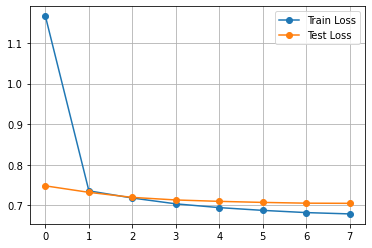

In [16]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(loss, 'o-')
plt.plot(val_loss, 'o-')
plt.grid()
plt.legend(['Train Loss', 'Test Loss'])

## Making Predictions!

Select a random user, `user_id`.  Then, for each movie index, use the model to predict the ratings. Set the predictions to `yhat`.

In [17]:
user_id = np.random.randint(0, num_users, 1)
movie_in = np.arange(num_movie)[:, None]
user_in = np.tile(user_id, (num_movie,1))
yhat = mod.predict([user_in, movie_in])

Print the names of the movies with the top 10 predicted ratings for the user as well as the average rating that those movies had.  You will see that the network may predict ratings above 5!  We could have avoided this by limiting the output.

In [18]:
yhat = yhat.ravel()
I = np.flipud(np.argsort(yhat))
n = 10
for i in range(n):
  j = I[i]
  movie_title = get_movie_title(j)
  print(' %-50s Predicted ratings = %5.2f Avg rating = %5.2f' % (movie_title, yhat[j], ymean[j]))

 Mamma Roma (1962)                                  Predicted ratings =  5.85 Avg rating =  4.50
 Year of the Horse (1997)                           Predicted ratings =  4.78 Avg rating =  5.00
 Six Ways to Sunday (1997)                          Predicted ratings =  4.75 Avg rating =  4.00
 Shawshank Redemption, The (1994)                   Predicted ratings =  4.74 Avg rating =  4.56
 Usual Suspects, The (1995)                         Predicted ratings =  4.71 Avg rating =  4.53
 Paralyzing Fear: The Story of Polio in America, A (1998) Predicted ratings =  4.69 Avg rating =  5.00
 American Beauty (1999)                             Predicted ratings =  4.65 Avg rating =  4.32
 Synthetic Pleasures (1995)                         Predicted ratings =  4.64 Avg rating =  3.67
 Sixth Sense, The (1999)                            Predicted ratings =  4.64 Avg rating =  4.40
 Aparajito (1956)                                   Predicted ratings =  4.64 Avg rating =  4.31


## Optimizing the Embedding Dimension  

In [19]:
emb_dim_opt = np.arange(9)
ntest = len(emb_dim_opt)
epochs = 10
hist_tot = []
val_loss = np.zeros(ntest)
loss = np.zeros(ntest)

for i, emb_dim in enumerate(emb_dim_opt):
  K.clear_session()

  mod = create_mod(emb_dim=emb_dim, nuser=num_users, nmovie=num_movie)
  opt = Adam(lr=0.01)
  mod.compile(optimizer=opt, loss='mean_absolute_error')

  hist = mod.fit(Xtr, ytr, epochs=epochs, batch_size=1000, verbose=0, validation_data=(Xts, yts))
  hist_tot.append(hist.history)

  val_loss[i] = hist.history['val_loss'][-1]
  loss[i] = hist.history['loss'][-1]
  print('Dimension= %d loss=%12.5e val_loss=%12.5e' %(emb_dim, loss[i], val_loss[i]))

Dimension= 0 loss= 7.12290e-01 val_loss= 7.17767e-01
Dimension= 1 loss= 6.99723e-01 val_loss= 7.07533e-01
Dimension= 2 loss= 6.91083e-01 val_loss= 7.07209e-01
Dimension= 3 loss= 6.81986e-01 val_loss= 7.04834e-01
Dimension= 4 loss= 6.73971e-01 val_loss= 7.03633e-01
Dimension= 5 loss= 6.68746e-01 val_loss= 7.06143e-01
Dimension= 6 loss= 6.59873e-01 val_loss= 7.03855e-01
Dimension= 7 loss= 6.57236e-01 val_loss= 7.06832e-01
Dimension= 8 loss= 6.48430e-01 val_loss= 7.04127e-01


Plot the training and test loss as a function of the embedding layer. We see we get a minimum with an embedding dimension around 4 or 5.

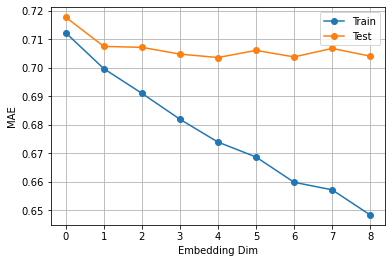

In [20]:
plt.plot(emb_dim_opt, loss, 'o-')
plt.plot(emb_dim_opt, val_loss, 'o-')
plt.xlabel('Embedding Dim')
plt.ylabel('MAE')
plt.grid()
plt.legend(['Train', 'Test'])